In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'DejaVu Sans'
import seaborn as sns

# To be able to save images on server
import matplotlib
%matplotlib inline
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Importing tensorflow
np.random.seed(42)
import tensorflow as tf


from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM , BatchNormalization
from keras.layers.core import Dense, Dropout
from keras.regularizers import L1L2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
reformed_xdata=np.load(r'C:\Users\ASUS\Documents\school\IM680\SleepySignals_X.npy')

In [3]:
len(reformed_xdata)

9228

In [4]:
reformed_ydata=np.load(r'C:\Users\ASUS\Documents\school\IM680\SleepySignals_y.npy')

In [5]:
patient_list=[1351,2510,2939,4301,5852,5995,7257,7838,7844,8898]

In [6]:
patient_record= [982, 923, 886, 919, 861, 1057, 941, 902, 888, 869]

In [7]:
patient_loc=[]
for i, x in enumerate(patient_record):
    
    patient_loc.append(sum(patient_record[0:i]))

In [8]:
patient_loc.append(len(reformed_xdata))

In [9]:
lb = preprocessing.LabelBinarizer()

In [10]:
lb.fit(reformed_ydata)

LabelBinarizer()

In [11]:
reformed_ydata_binary=lb.transform(reformed_ydata)

In [12]:
xdata=np.asarray(reformed_xdata)

## data exploration: hypnograms

In [ ]:
def hypnogram(pid):
    fig, ax = plt.subplots(figsize=(10,4))

    ax.plot(range(len(reformed_ydata[patient_loc[pid]:patient_loc[pid+1]])),reformed_ydata[patient_loc[pid]:patient_loc[pid+1]],label='True Label')
    y_label_list = ['W', 'N1', 'N2' , 'N3/N4', 'REM']
    ax.set_yticks([0,1,2,3,4])
    ax.set_yticklabels(y_label_list)
    ax.set_xlabel('Hours')
    ax.set_ylabel('Sleep Stages')
    ax.set_title('Hypnogram for Patient: '+str(patient_list[pid]))
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = 'W', 'N1', 'N2' , 'N3/N4', 'REM'
    sizes = [list(reformed_ydata[patient_loc[pid]:patient_loc[pid+1]]).count(x) for x in range(0,5)]
    explode = (0, 0, 0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

    fig1, ax1 = plt.subplots(figsize=(6,6))
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title('Sleep distribution for Patient: '+str( patient_list[pid]) )

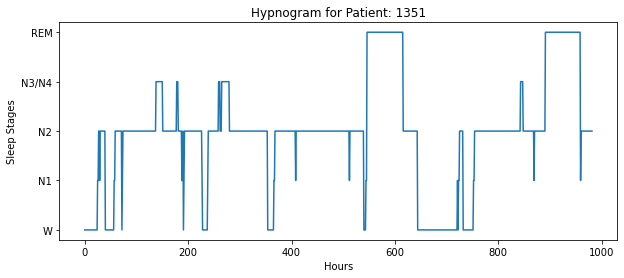

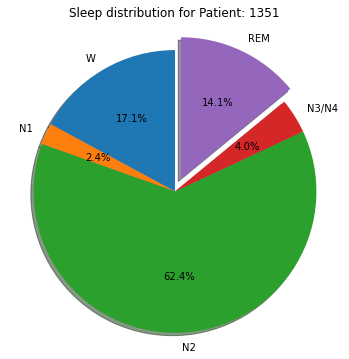

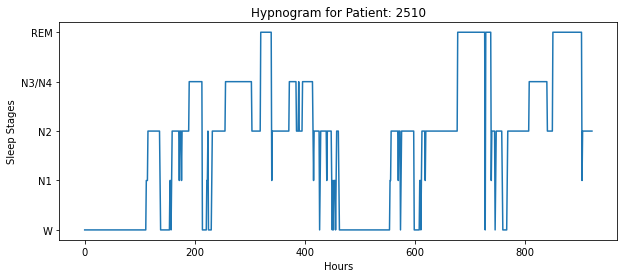

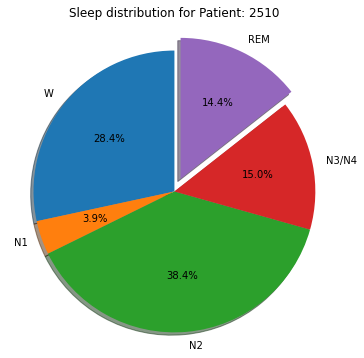

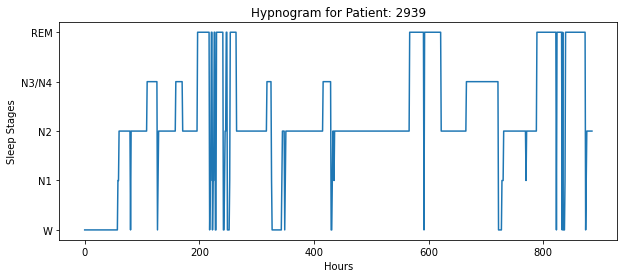

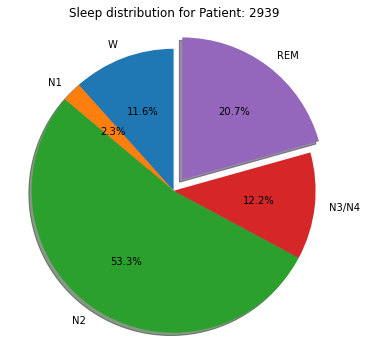

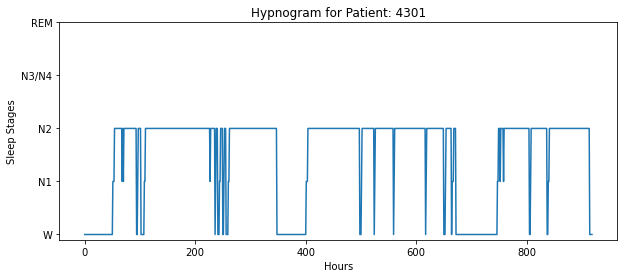

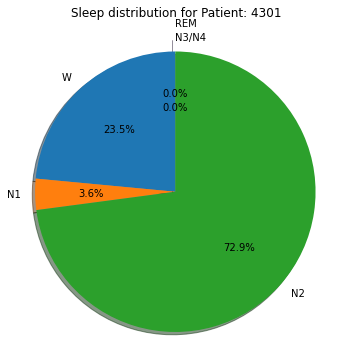

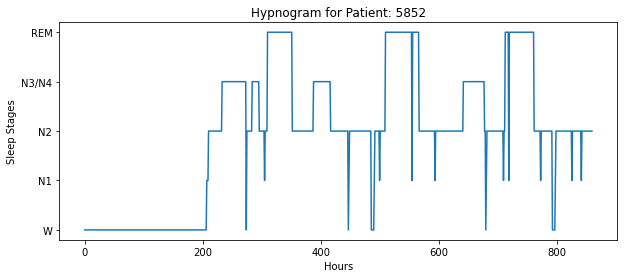

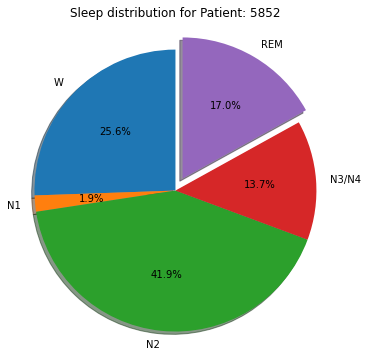

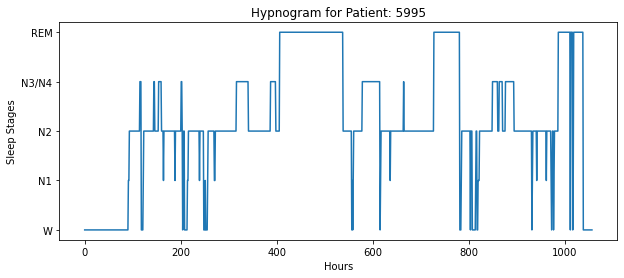

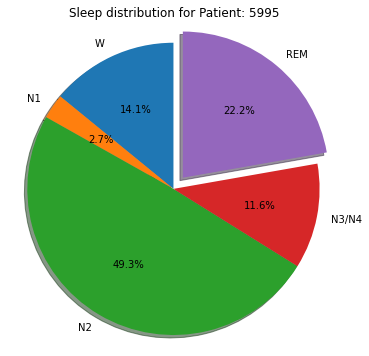

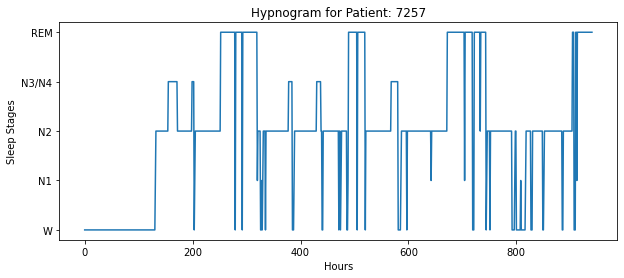

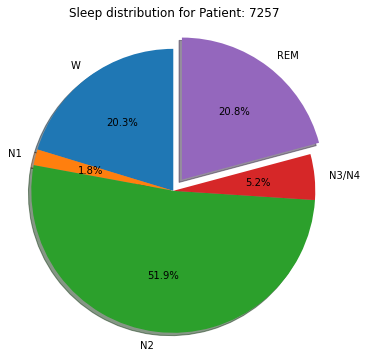

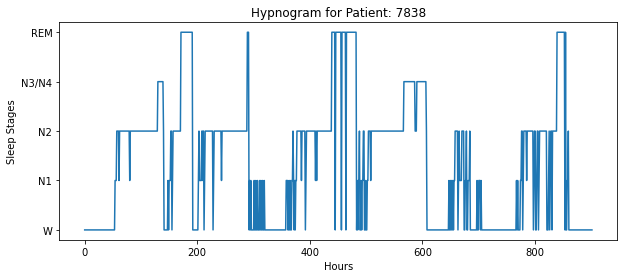

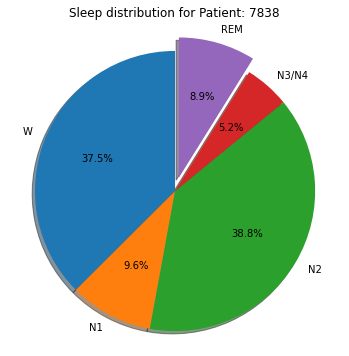

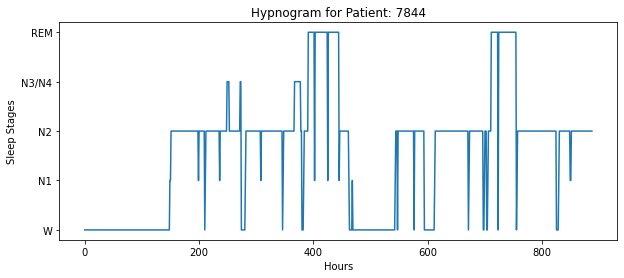

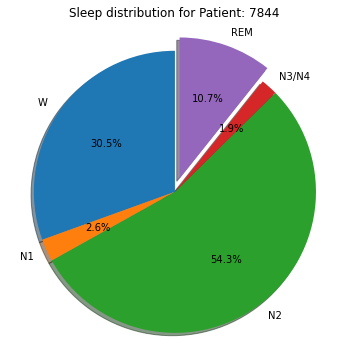

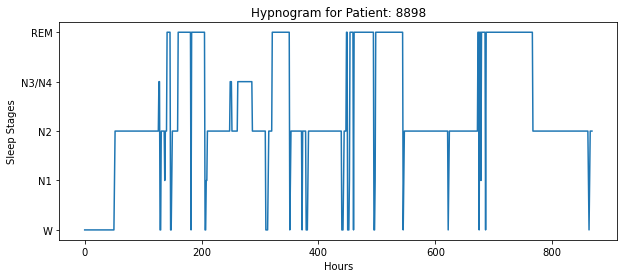

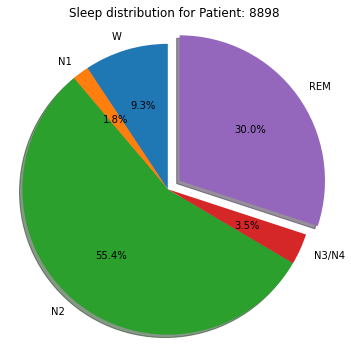

In [14]:
for i in range(10):
    hypnogram(i)

# using the first patient as test data

In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(xdata, reformed_ydata_binary, test_size=0.2, random_state=42)

In [37]:
pid=1

In [50]:
x_test = xdata[patient_loc[pid]:patient_loc[pid+1] ];
y_test = reformed_ydata_binary[patient_loc[pid]:patient_loc[pid+1]]
x_train = np.concatenate((xdata[0:patient_loc[pid]],xdata[patient_loc[pid+1]:]))
y_train = np.concatenate((reformed_ydata_binary[0:patient_loc[pid]],reformed_ydata_binary[patient_loc[pid+1]:]))

In [53]:
y_train_true = np.concatenate((reformed_ydata[0:patient_loc[pid]],reformed_ydata[patient_loc[pid+1]:]))

In [54]:
y_test_true = reformed_ydata[patient_loc[pid]:patient_loc[pid+1]]

Text(0.5, 1.0, 'Sleep distribution for training data.')

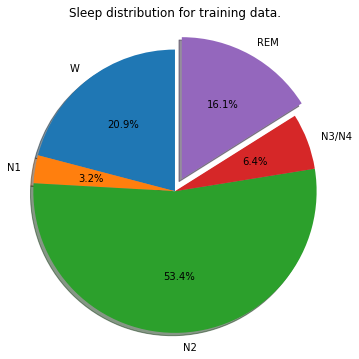

In [57]:
labels = 'W', 'N1', 'N2' , 'N3/N4', 'REM'
sizes = [list(y_train_true).count(x) for x in range(0,5)]
explode = (0, 0, 0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Sleep distribution for training data.' )

## clearly we have class imbalance

### method 1: we train with class weights (we will try this method first)
### method 2: we manually augument the dataset

In [60]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(list(y_train_true)),
                                                 list(y_train_true))

In [62]:
class_weights = dict(enumerate(class_weights))

In [64]:
timesteps = len(x_train[0])
input_dim = len(x_train[0][0])
n_classes = len(y_train[0])

In [65]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [66]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'W',
    1: 'N1',
    2: 'N2',
    3: 'N3/N4',
    4: 'REM'
}


# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "channel1_gyo_x",
    "channel1_gyo_y",
    "channel1_gyo_z",
    "channel2_gyo_x",
    "channel2_gyo_y",
    "channel2_gyo_z",
    
    
    "channel1_acc_x",
    "channel1_acc_y",
    "channel1_acc_z",
    "channel2_acc_x",
    "channel2_acc_y",
    "channel2_acc_z",
    
    "EEG1 channel 1",
    "EEG1 channel 2",
    "EEG2 channel 1",
    "EEG2 channel 2",
]

In [67]:
def confusion_matrix_dl(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])
    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [68]:
def plot_train_cv_loss(trained_model, epochs, colors=['b']):
    fig, ax = plt.subplots(1,1)    
    ax.set_xlabel('epoch') 
    ax.set_ylabel('Categorical Crossentropy Loss')
    x_axis_values = list(range(1,epochs+1))

    validation_loss = trained_model.history['val_loss']
    train_loss = trained_model.history['loss']   
    
    ax.plot(x_axis_values, validation_loss, 'b', label="Validation Loss")
    ax.plot(x_axis_values, train_loss, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw() 

In [69]:
def plot_confusion_matrix_lstm(y_test, y_predict):
    result = confusion_matrix(y_test, y_predict)

    plt.figure(figsize=(12, 10))
    sns.heatmap(result, 
                xticklabels=list(ACTIVITIES.values()), 
                yticklabels=list(ACTIVITIES.values()), 
                annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 

In [70]:
n_steps = 30;
n_length = 100;
n_features =input_dim ;

x_train = x_train.reshape((x_train.shape[0], n_steps, n_length, n_features))
x_test = x_test.reshape((x_test.shape[0], n_steps, n_length, n_features))

# CNN-LSTM model

In [71]:
from keras.layers import TimeDistributed, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [72]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
print("Model Summary: ")
model.summary()

Model Summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, None, 98, 64)      3136      
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 96, 64)      12352     
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 96, 64)      0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 48, 64)      0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, None, 3072)        0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               1269200   
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0    

In [73]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [74]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
start = datetime.now()
n_epochs=20;n_batch = 16;
# Training the model
trained_model_CNN_LSTM  = model.fit(x_train,
                          y_train,
                          batch_size=n_batch,
                          class_weight=class_weights,
                          validation_data=(x_test, y_test),
                          epochs=n_epochs,callbacks=[callback],shuffle=True)

print("\n Time Taken: ",datetime.now() - start)

Train on 8305 samples, validate on 923 samples
Epoch 1/20
8305/8305 [==============================] - 163s 20ms/step - loss: 1.4929 - acc: 0.2859 - val_loss: 1.7623 - val_acc: 0.2080
Epoch 2/20
8305/8305 [==============================] - 183s 22ms/step - loss: 1.4290 - acc: 0.2955 - val_loss: 1.6509 - val_acc: 0.1668
Epoch 3/20
8305/8305 [==============================] - 253s 30ms/step - loss: 1.3947 - acc: 0.2916 - val_loss: 1.6671 - val_acc: 0.1582
Epoch 4/20
8305/8305 [==============================] - 167s 20ms/step - loss: 1.3759 - acc: 0.3221 - val_loss: 1.6736 - val_acc: 0.1972
Epoch 5/20
8305/8305 [==============================] - 167s 20ms/step - loss: 1.4075 - acc: 0.2918 - val_loss: 1.6208 - val_acc: 0.3283
Epoch 6/20
8305/8305 [==============================] - 162s 19ms/step - loss: 1.3856 - acc: 0.2920 - val_loss: 1.7014 - val_acc: 0.2134
Epoch 7/20
8305/8305 [==============================] - 201s 24ms/step - loss: 1.3902 - acc: 0.2808 - val_loss: 1.6525 - val_acc: 0


Test Accuracy: 40.953413%



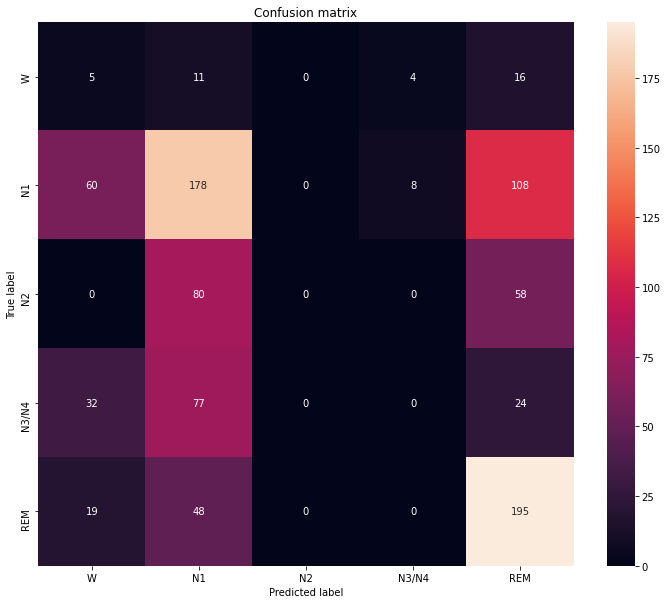

In [75]:
print()
scores = model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy: %f%%" % (scores[1]*100))
print()

Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model.predict(x_test), axis=1)])

# Confusion Matrix
plot_confusion_matrix_lstm(Y_true, Y_predictions)

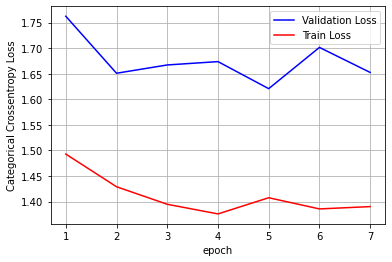

In [77]:
# Plot train and cross validation error
plot_train_cv_loss(trained_model_CNN_LSTM, 7)

In [78]:
from sklearn.metrics import classification_report, roc_curve, auc,roc_auc_score,cohen_kappa_score
from scipy import interp
from itertools import cycle

In [79]:
y_predicted=model.predict(x_test)

In [80]:
Y_pred_value = [y for y in np.argmax(y_predicted, axis=1)]

Y_true_value = [y for y in np.argmax(y_test, axis=1)]

In [81]:
roc_auc_score(y_test, y_predicted, average="weighted", multi_class="ovr")

0.6186687108597061

In [82]:
cohen_kappa_score(Y_true_value, Y_pred_value)

0.16386450560903176

In [83]:
print(classification_report(Y_true_value, Y_pred_value))

              precision    recall  f1-score   support

           0       0.49      0.74      0.59       262
           1       0.04      0.14      0.07        36
           2       0.45      0.50      0.48       354
           3       0.00      0.00      0.00       138
           4       0.00      0.00      0.00       133

    accuracy                           0.41       923
   macro avg       0.20      0.28      0.23       923
weighted avg       0.31      0.41      0.35       923



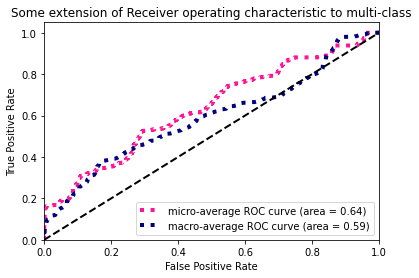

In [84]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_predicted[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_predicted.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

lw=2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(n_classes), colors):
#    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#             label='ROC curve of class {0} (area = {1:0.2f})'
#             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [85]:
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalMaxPool1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D, TimeDistributed, Bidirectional, LSTM
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, MaxPool1D, Activation
from tensorflow.keras.layers import Reshape, LSTM, TimeDistributed, Bidirectional, BatchNormalization, Flatten, RepeatVector
from tensorflow.keras.optimizers import Adam
from keras_contrib.layers import CRF

# coarse and fine cnns-lstm model

In [86]:
WINDOW_SIZE = 100
Fs = 100

In [87]:
def model_b(n_classes=5, use_sub_layer=False, use_rnn=True, verbose=False):
    """Recurrent_Deep_Neural_Networks_for_Real-Time_Sleep
    """
    inputLayer = Input(shape=(3000, 16), name='inLayer')
    convFine = Conv1D(filters=64, kernel_size=int(Fs/2), strides=int(Fs/16), padding='same', activation='relu', name='fConv1')(inputLayer)
    convFine = MaxPool1D(pool_size=8, strides=8, name='fMaxP1')(convFine)
    convFine = Dropout(rate=0.5, name='fDrop1')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv2')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv3')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv4')(convFine)
    convFine = MaxPool1D(pool_size=4, strides=4, name='fMaxP2')(convFine)
    fineShape = convFine.get_shape()
    convFine = Flatten(name='fFlat1')(convFine)
    
    # network to learn coarse features
    convCoarse = Conv1D(filters=32, kernel_size=Fs*4, strides=int(Fs/2), padding='same', activation='relu', name='cConv1')(inputLayer)
    convCoarse = MaxPool1D(pool_size=4, strides=4, name='cMaxP1')(convCoarse)
    convCoarse = Dropout(rate=0.5, name='cDrop1')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv2')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv3')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv4')(convCoarse)
    convCoarse = MaxPool1D(pool_size=2, strides=2, name='cMaxP2')(convCoarse)
    coarseShape = convCoarse.get_shape()
    convCoarse = Flatten(name='cFlat1')(convCoarse)
    
    # concatenate coarse and fine cnns
    mergeLayer = concatenate([convFine, convCoarse], name='merge_1')
    outLayer = Dropout(rate=0.5, name='mDrop1')(mergeLayer)
    
    outLayer = Reshape((1, outLayer.get_shape()[1]), name='reshape1')(outLayer)
    outLayer = LSTM(64, return_sequences=True)(outLayer)
    outLayer = LSTM(64, return_sequences=False)(outLayer)

    # Classify
    outLayer = Dense(n_classes, activation='softmax', name='outLayer')(outLayer)
    model = Model(inputLayer, outLayer)
    optimizer = Adam(lr=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
    if verbose:
        model.summary()
    return model

In [89]:
model_CRF=model_b()

In [90]:
x_train = x_train.reshape((x_train.shape[0],3000, n_features))
x_test = x_test.reshape((x_test.shape[0], 3000, n_features))

In [100]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
start = datetime.now()
n_epochs=30;n_batch=64;
# Training the model
trained_model_CRF= model_CRF.fit(x_train,
                           y_train,
                           batch_size=n_batch,
                           class_weight=class_weights,
                          validation_data=(x_test, y_test),
                          epochs=n_epochs,callbacks=[callback],shuffle=True)

print("\n Time Taken: ",datetime.now() - start)

Train on 8305 samples, validate on 923 samples
Epoch 1/30
8305/8305 [==============================] - 38s 5ms/sample - loss: 0.5559 - acc: 0.7060 - val_loss: 2.7425 - val_acc: 0.3174
Epoch 2/30
8305/8305 [==============================] - 37s 5ms/sample - loss: 0.5607 - acc: 0.7170 - val_loss: 3.0041 - val_acc: 0.2286
Epoch 3/30
8305/8305 [==============================] - 41s 5ms/sample - loss: 0.5390 - acc: 0.7093 - val_loss: 2.8223 - val_acc: 0.2687
Epoch 4/30
8305/8305 [==============================] - 46s 5ms/sample - loss: 0.5658 - acc: 0.7066 - val_loss: 2.8024 - val_acc: 0.2752
Epoch 5/30
8305/8305 [==============================] - 46s 6ms/sample - loss: 0.5379 - acc: 0.7117 - val_loss: 2.8144 - val_acc: 0.2752
Epoch 6/30
8305/8305 [==============================] - 65s 8ms/sample - loss: 0.5401 - acc: 0.7117 - val_loss: 2.7725 - val_acc: 0.1939
Epoch 7/30
8305/8305 [==============================] - 64s 8ms/sample - loss: 0.5380 - acc: 0.7127 - val_loss: 2.9132 - val_acc: 0

In [101]:
y_full_predicted=model_CRF.predict(xdata)

In [102]:
y_predicted=model_CRF.predict(x_test)

In [103]:
first_patient_duration=982;

In [104]:
Y_all_predicted = [y for y in np.argmax(y_full_predicted, axis=1)]

In [105]:
Y_all_true = [y for y in np.argmax(reformed_ydata_binary, axis=1)]

In [106]:
Y_pred_value = [y for y in np.argmax(y_predicted, axis=1)]

Y_true_value = [y for y in np.argmax(y_test, axis=1)]

Text(0, 0.5, 'PSG graph')

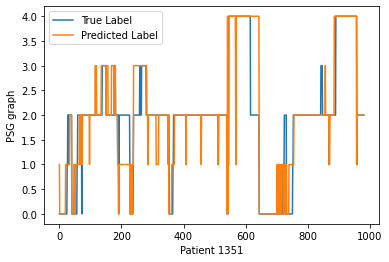

In [107]:
plt.plot(range(len(reformed_ydata[:first_patient_duration])),Y_all_true[:first_patient_duration],label='True Label')
plt.plot(range(len(reformed_ydata[:first_patient_duration])),Y_all_predicted[:first_patient_duration],label='Predicted Label')
plt.legend()
plt.xlabel('Patient 1351')
plt.ylabel('PSG graph')


Test Accuracy: 18.634886%



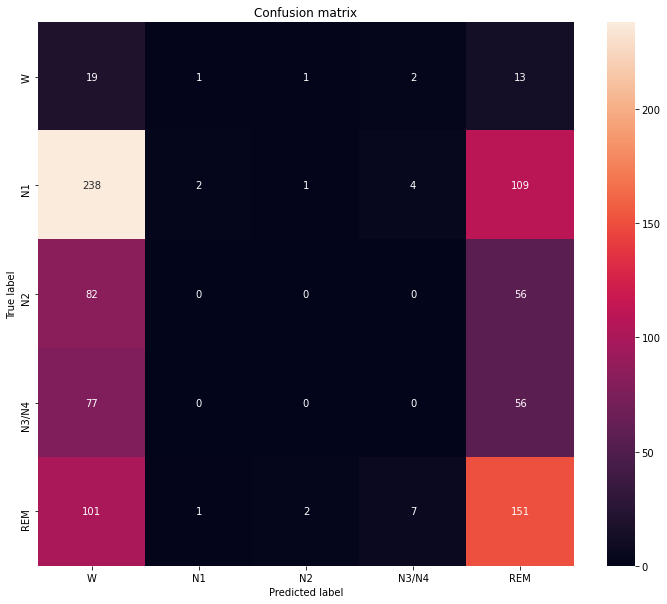

In [108]:
print()
scores = model_CRF.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy: %f%%" % (scores[1]*100))
print()

Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model_CRF.predict(x_test), axis=1)])

# Confusion Matrix
plot_confusion_matrix_lstm(Y_true, Y_predictions)

ValueError: x and y must have same first dimension, but have shapes (30,) and (15,)

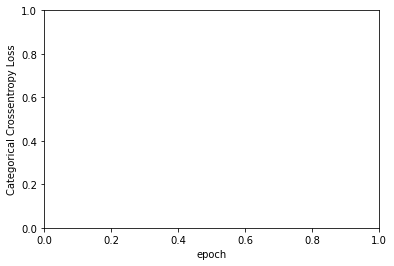

In [109]:
# Plot train and cross validation error
plot_train_cv_loss(trained_model_CRF, n_epochs)

In [ ]:
roc_auc_score(y_test, y_predicted, average="weighted", multi_class="ovr")

In [ ]:
cohen_kappa_score(Y_true_value, Y_pred_value)

In [ ]:
print(classification_report(Y_true_value, Y_pred_value))

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_predicted[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_predicted.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

lw=2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(n_classes), colors):
#    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#             label='ROC curve of class {0} (area = {1:0.2f})'
#             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.datasets import make_classification

In [ ]:
x_train_RF = x_train.reshape((x_train.shape[0], 3000 * n_features))
x_test_RF = x_test.reshape((x_test.shape[0], 3000* n_features))

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(x_train_RF, y_train)

In [ ]:
y_RF_pred=clf.predict(x_test_RF)

In [ ]:
roc_auc_score(y_test,y_RF_pred, average="weighted", multi_class="ovr")

In [ ]:
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(y_RF_pred, axis=1)])

# Confusion Matrix
plot_confusion_matrix_lstm(Y_true, Y_predictions)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_RF_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_RF_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

lw=2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(n_classes), colors):
#    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#             label='ROC curve of class {0} (area = {1:0.2f})'
#             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(classification_report(Y_true, Y_predictions))